<a target="_blank" href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/2-Advance/FinRL_Ensemble_StockTrading_ICAIF_2020.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading Using Ensemble Strategy

Tutorials to use OpenAI DRL to trade multiple stocks using ensemble strategy in one Jupyter Notebook | Presented at ICAIF 2020

* This notebook is the reimplementation of our paper: Deep Reinforcement Learning for Automated Stock Trading: An Ensemble Strategy, using FinRL.
* Check out medium blog for detailed explanations: https://medium.com/@ai4finance/deep-reinforcement-learning-for-automated-stock-trading-f1dad0126a02
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version**



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [1]:
# # ## install finrl library
# !pip install wrds
# !pip install swig
# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them.
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

<a id='1.4'></a>
## 2.4. Create Folders

In [5]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [6]:
from dataloader import *

collector = OurDatasetCollector()
df = collector.ReadFromFolder("VNstock")
df

read VNstock\ACB.csv
read VNstock\BID.csv
read VNstock\BVH.csv
read VNstock\FPT.csv
read VNstock\VIC.csv
Number of duplicated rows: 0
Number of missing values: 0
Largest minimum date across all tics: 2014-01-27
Smallest maximum date across all tics: 2024-05-23
Day of the week counts:
0: 2525
1: 2580
2: 2575
3: 2595
4: 2580


,date,open,high,low,close,volume,tic,day
1,2024-05-23,45500.0,45900.0,44400.0,45550.0,2650000.0,ACB,3
2,2024-05-22,43200.0,47000.0,43200.0,47000.0,3150000.0,ACB,2
3,2024-05-21,43450.0,47700.0,43450.0,46450.0,3340000.0,ACB,1
4,2024-05-20,47000.0,48900.0,45900.0,46700.0,3220000.0,ACB,0
5,2024-05-17,46750.0,47000.0,46250.0,46850.0,2170000.0,ACB,4
...,...,...,...,...,...,...,...,...
2567,2014-02-11,41162.0,41162.0,40628.0,40895.0,1150000.0,VIC,1
2568,2014-02-10,39826.0,40628.0,39826.0,40628.0,176570.0,VIC,0
2569,2014-02-07,40895.0,40895.0,39559.0,39826.0,417660.0,VIC,4
2570,2014-02-06,40895.0,40895.0,39826.0,40360.0,493200.0,VIC,3


In [7]:
import pandas as pd
df['date'] = pd.to_datetime(df['date'])
result = df.groupby('tic')['date'].agg(['min', 'max']).reset_index()
print(result)


   tic        min        max
0  ACB 2014-01-27 2024-05-23
1  BID 2014-01-27 2024-05-23
2  BVH 2014-01-27 2024-05-23
3  FPT 2014-01-27 2024-05-23
4  VIC 2014-01-27 2024-05-23


# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [8]:
INDICATORS = ['macd',
               'rsi_30',
               'cci_30',
               'dx_30']

In [9]:
from finrl.meta.preprocessor.preprocessors import FeatureEngineer
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

Successfully added technical indicators
Successfully added turbulence index


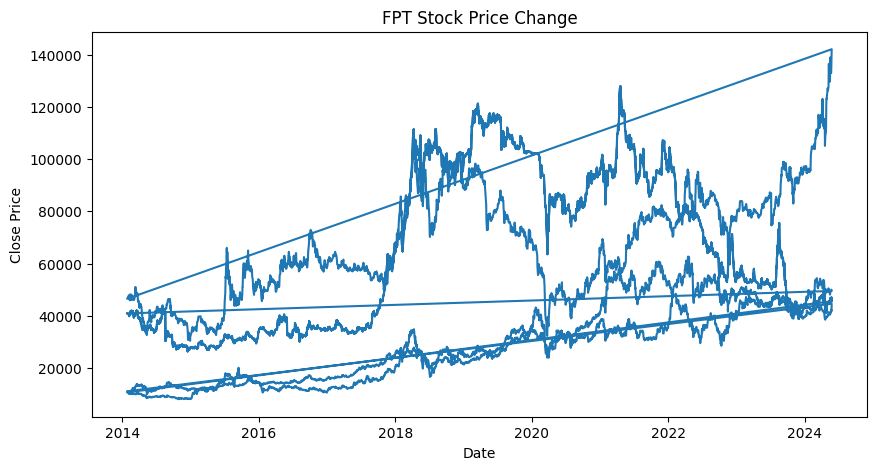

In [11]:
# plot df price change in 2009-2023

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(df['date'], df['close'])
plt.title('FPT Stock Price Change')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [12]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 5, State Space: 31


In [10]:
env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "print_verbosity":10

}

# buy_cost_list = sell_cost_list = [0.001] * stock_dimension
# num_stock_shares = [0] * stock_dimension
# env_kwargs = {
#     "hmax": 100,
#     "initial_amount": 1000000,
#     "num_stock_shares": num_stock_shares,
#     "buy_cost_pct": buy_cost_list,
#     "sell_cost_pct": sell_cost_list,
#     "state_space": state_space,
#     "stock_dim": stock_dimension,
#     "tech_indicator_list": INDICATORS,
#     "action_space": stock_dimension,
#     "reward_scaling": 1e-4
# }

<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

* In this notebook, we are training and validating 3 agents (A2C, PPO, DDPG) using Rolling-window Ensemble Method ([reference code](https://github.com/AI4Finance-LLC/Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020/blob/80415db8fa7b2179df6bd7e81ce4fe8dbf913806/model/models.py#L92))

In [17]:
rebalance_window = 32 # rebalance_window is the number of days to retrain the model
validation_window = 32 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window,
                 validation_window=validation_window,
                 **env_kwargs)
# e_train_gym = StockTradingEnv(df = processed, **env_kwargs)
# agent = DRLAgent(e_train_gym)
# if_using_a2c = True
# model_a2c = agent.get_model("a2c")
# # if if_using_a2c:
# #   tmp_path = RESULTS_DIR + '/a2c'
# #   new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# #   model_a2c.set_logger(new_logger_a2c)
# trained_a2c = agent.train_model(model=model_a2c,
#                              tb_log_name='a2c',
#                              total_timesteps=50000)

In [18]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 10_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

SAC_model_kwargs = {
    "batch_size": 64,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

TD3_model_kwargs = {"batch_size": 100, "buffer_size": 1000000, "learning_rate": 0.0001}




timesteps_dict = {'a2c' : 10_000,
                 'ppo' : 10_000,
                 'ddpg' : 10_000,
                 'sac' : 10_000,
                 'td3' : 10_000
                 }

In [19]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 SAC_model_kwargs,
                                                 TD3_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  11.19344937303243
======Model training from:  2014-01-27 to  2022-08-02
======a2c Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cuda device
Logging to tensorboard_log/a2c\a2c_64_1
------------------------------------
| time/                 |          |
|    fps                | 187      |
|    iterations         | 100      |
|    time_elapsed       | 2        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.43    |
|    explained_variance | -0.0144  |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 8.15     |
|    reward             | 1.3376   |
|    std                | 1.01     |
|    value_loss         | 74.6     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 200      |
|    itera

KeyboardInterrupt: 

In [ ]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe,SAC Sharpe,TD3 Sharpe
0,126,2021-08-02,2021-11-01,PPO,-0.257912,0.176535,0.0,0.0,0.0
1,189,2021-11-01,2022-01-28,TD3,-0.26132,-0.363428,-0.284985,-0.284985,0.0
2,252,2022-01-28,2022-05-09,PPO,0.157494,0.190009,0.0,0.0,0.0


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [ ]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

In [ ]:
import pandas as pd

# Ensure these variables are defined
# unique_trade_date should be a list or array of dates
# rebalance_window and validation_window should be integers

df_trade_date = pd.DataFrame({'datadate': unique_trade_date})

# Initialize an empty DataFrame for account values
df_account_value = pd.DataFrame()

# Loop through the specified range to read and concatenate CSV files
for i in range(rebalance_window + validation_window, len(unique_trade_date) + 1, rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble', i))
    df_account_value = pd.concat([df_account_value, temp], ignore_index=True)

# Calculate Sharpe Ratio
returns = df_account_value['account_value'].pct_change(1)
sharpe_ratio = (252**0.5) * returns.mean() / returns.std()

print('Sharpe Ratio: ', sharpe_ratio)

# Join with trade dates DataFrame, aligning indices properly
df_account_value = df_account_value.reset_index(drop=True)
df_trade_date_adjusted = df_trade_date.iloc[validation_window:].reset_index(drop=True)
df_account_value = df_account_value.join(df_trade_date_adjusted)

print(df_account_value)

Sharpe Ratio:  -0.41967476312690394
     account_value        date  daily_return    datadate
0      1000000.000  2021-11-01           NaN  2021-11-01
1      1000000.000  2021-11-02      0.000000  2021-11-02
2      1000000.000  2021-11-03      0.000000  2021-11-03
3      1000000.000  2021-11-04      0.000000  2021-11-04
4      1000000.000  2021-11-05      0.000000  2021-11-05
..             ...         ...           ...         ...
184     936214.914  2022-07-28     -0.000989  2022-07-28
185     920067.750  2022-07-29     -0.017247  2022-07-29
186     920892.430  2022-08-01      0.000896  2022-08-01
187     920643.325  2022-08-02     -0.000271  2022-08-02
188     920643.325  2022-08-03      0.000000  2022-08-03

[189 rows x 4 columns]


In [ ]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,1000000.0,2021-11-01,NaN,2021-11-01
1,1000000.0,2021-11-02,0.0,2021-11-02
2,1000000.0,2021-11-03,0.0,2021-11-03
3,1000000.0,2021-11-04,0.0,2021-11-04
4,1000000.0,2021-11-05,0.0,2021-11-05


<Axes: >

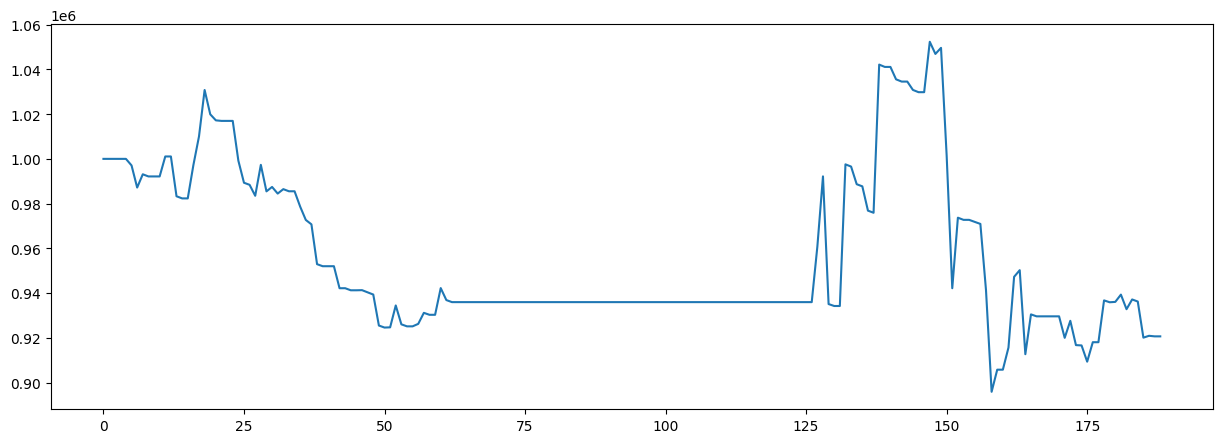

In [ ]:
%matplotlib inline
df_account_value.account_value.plot()

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [ ]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return         -0.104384
Cumulative returns    -0.079357
Annual volatility      0.211198
Sharpe ratio          -0.419675
Calmar ratio          -0.701966
Stability              0.089912
Max drawdown          -0.148702
Omega ratio            0.881344
Sortino ratio         -0.593089
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.098177
Daily value at risk   -0.026960
dtype: float64


In [ ]:
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

[*********************100%%**********************]  1 of 1 completed

==============Get Baseline Stats===========
Shape of DataFrame:  (189, 8)
Annual return         -0.128416
Cumulative returns    -0.097947
Annual volatility      0.185608
Sharpe ratio          -0.651699
Calmar ratio          -0.683803
Stability              0.751819
Max drawdown          -0.187797
Omega ratio            0.897953
Sortino ratio         -0.874012
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.820518
Daily value at risk   -0.023864
dtype: float64


In [ ]:
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value['date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji+.csv")

df_account_value.to_csv('df_account_value.csv')


df_dji:             date           dji
0    2021-11-01  1.000000e+06
1    2021-11-02  1.003865e+06
2    2021-11-03  1.006787e+06
3    2021-11-04  1.005858e+06
4    2021-11-05  1.011531e+06
..          ...           ...
184  2022-07-28  8.965232e+05
185  2022-07-29  9.057687e+05
186  2022-08-01  9.145535e+05
187  2022-08-02  9.132523e+05
188  2022-08-03  9.020525e+05

[189 rows x 2 columns]
df_dji:                       dji
date                    
2021-11-01  1.000000e+06
2021-11-02  1.003865e+06
2021-11-03  1.006787e+06
2021-11-04  1.005858e+06
2021-11-05  1.011531e+06
...                  ...
2022-07-28  8.965232e+05
2022-07-29  9.057687e+05
2022-08-01  9.145535e+05
2022-08-02  9.132523e+05
2022-08-03  9.020525e+05

[189 rows x 1 columns]


<a id='6.2'></a>
## 7.2 BackTestPlot

df_result_ensemble.columns:  Index(['ensemble'], dtype='object')
df_trade_date:         datadate
0    2021-08-02
1    2021-08-03
2    2021-08-04
3    2021-08-05
4    2021-08-06
..          ...
287  2022-09-26
288  2022-09-27
289  2022-09-28
290  2022-09-29
291  2022-09-30

[292 rows x 1 columns]
df_result_ensemble:                 ensemble
date                   
2021-11-01  1000000.000
2021-11-02  1000000.000
2021-11-03  1000000.000
2021-11-04  1000000.000
2021-11-05  1000000.000
...                 ...
2022-07-28   936214.914
2022-07-29   920067.750
2022-08-01   920892.430
2022-08-02   920643.325
2022-08-03   920643.325

[189 rows x 1 columns]
==============Compare to DJIA===========
result:                 ensemble           dji
date                                 
2021-11-01  1000000.000  1.000000e+06
2021-11-02  1000000.000  1.003865e+06
2021-11-03  1000000.000  1.006787e+06
2021-11-04  1000000.000  1.005858e+06
2021-11-05  1000000.000  1.011531e+06
...                 ...       

<Figure size 1500x500 with 0 Axes>

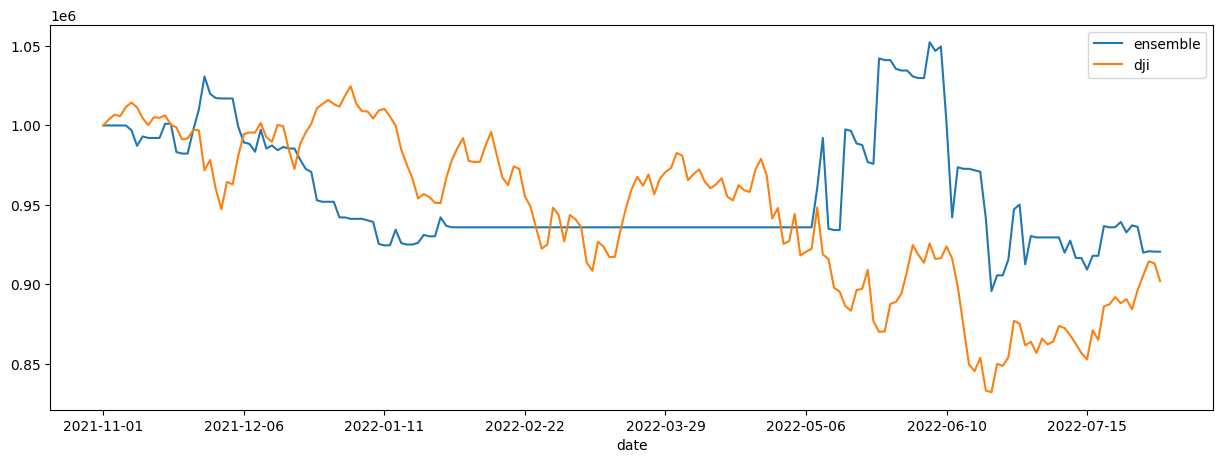

In [ ]:


# print("==============Compare to DJIA===========")
# %matplotlib inline
# # S&P 500: ^GSPC
# # Dow Jones Index: ^DJI
# # NASDAQ 100: ^NDX
# backtest_plot(df_account_value,
#               baseline_ticker = '^DJI',
#               baseline_start = df_account_value.loc[0,'date'],
#               baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])
df.to_csv("df.csv")
df_result_ensemble = pd.DataFrame({'date': df_account_value['date'], 'ensemble': df_account_value['account_value']})
df_result_ensemble = df_result_ensemble.set_index('date')

print("df_result_ensemble.columns: ", df_result_ensemble.columns)

# df_result_ensemble.drop(df_result_ensemble.columns[0], axis = 1)
print("df_trade_date: ", df_trade_date)
# df_result_ensemble['date'] = df_trade_date['datadate']
# df_result_ensemble['account_value'] = df_account_value['account_value']
df_result_ensemble.to_csv("df_result_ensemble.csv")
print("df_result_ensemble: ", df_result_ensemble)
print("==============Compare to DJIA===========")
result = pd.DataFrame()
# result = pd.merge(result, df_result_ensemble, left_index=True, right_index=True)
# result = pd.merge(result, df_dji, left_index=True, right_index=True)
result = pd.merge(df_result_ensemble, df_dji, left_index=True, right_index=True)
print("result: ", result)
result.to_csv("result.csv")
result.columns = ['ensemble', 'dji']

%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();